In [1]:
import os
import sys
import csv
import h5py
import argparse
import numpy as np
from collections import Counter

# 3rd party imports
from sklearn import manifold
from keras.models import Model
from keras import backend as K
from IPython.display import Image

# ML4CVD Imports
from ml4cvd.defines import TENSOR_EXT
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from ml4cvd.models import make_multimodal_to_multilabel_model, train_model_from_generators, make_hidden_layer_model
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
gene2samples = {}
samples2genes = {}
tensor_path_prefix = '/mnt/disks/pix-size-tensors/2019-04-29/'
with open('/home/sam/genes_mri_ecg_carriers_sampleid.tsv', 'r') as my_tsv:
    lol = list(csv.reader(my_tsv, delimiter='\t'))
for row in lol[1:]:
    sample_list = [tensor_path_prefix + t + TENSOR_EXT for t in row[6].split(';')]
    gene2samples[row[0]] = sample_list
    for s in sample_list:
        samples2genes[s] = row[0]
print(list(gene2samples.keys()))
gene_labels = ['TTN', 'AKAP9', 'DSC2', 'NEBL', 'RYR2', 'TRDN']

['ABCC9', 'AKAP9', 'ALMS1', 'ANK2', 'BAG3', 'CACNA1C', 'CALM1', 'CALM2', 'CALM3', 'CAV3', 'CSRP3', 'DSC2', 'DSP', 'FKTN', 'GAA', 'GATA4', 'GLA', 'KCNE1', 'KCNE2', 'KCNH2', 'KCNJ2', 'KCNJ5', 'KCNQ1', 'LDB3', 'LMNA', 'MIB1', 'MYBPC3', 'MYH7', 'MYOM1', 'NEBL', 'NKX2-5', 'PKP2', 'RYR2', 'SCN4B', 'SCN5A', 'SLC22A5', 'SNTA1', 'TCAP', 'TRDN', 'TTN', 'TTR', 'TXNRD2']


In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole_weighted', 'mri_pixel_width', 'mri_pixel_height',
            '--output_tensors','mri_systole_diastole_segmented_weighted', 'end_systole_volume',
                                'end_diastole_volume', 'ejection_fraction', 'lv_mass',
            '--batch_size', '12',
            '--pool_z', '1',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--u_connect',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '5',
            '--model_file', '/home/sam/ml/trained_models/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef.hd5',
            '--id', 'mri_systole_diastole_unet_lv_mass_diseases']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                   args.tensor_maps_out,
                                                                                   args.tensors, 
                                                                                   args.batch_size,
                                                                                   args.valid_ratio,
                                                                                   args.test_ratio,
                                                                                   args.icd_csv,
                                                                                   args.balance_by_icds)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-31 14:48:27,653 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_systole_diastole_unet_lv_mass_diseases/log_2019-05-31_14-48_0.log.
2019-05-31 14:48:27,654 - arguments:247 - INFO - Total TensorMaps:1249 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=12, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2

2019-05-31 14:48:36,406 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 86, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['batch_index']] = tm.tensor_from_file(hd5)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 461, in tensor_from_file
    raise ValueError(self.name + ' is a continuous value that cannot be set to 0, but no value was found.')
ValueError: lv_mass is a continuous value that cannot be set to 0, but no value was found.


2019-05-31 14:48:36,421 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 80, in multimodal_multitask_generator
    in_batch[tm.input_name()][stats['batch_index']] = tm.tensor_f

In [6]:
gene2batch = {}
for g in gene2samples:
    gene_generator = TensorGenerator(8, args.tensor_maps_in, args.tensor_maps_out, gene2samples[g], None, True)
    if g in gene_labels:
        gene2batch[g] = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out, gene_generator, args.test_steps) 

2019-05-31 14:49:56,796 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2006372.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:56,798 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:56,857 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5974763.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:56,875 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:56,905 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1575461.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:56,908 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:56,977 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2734382.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:56,978 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,017 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3130716.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,018 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,028 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3860415.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,030 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,057 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2495853.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,071 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,124 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3017171.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,125 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,210 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3957052.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,211 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,221 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5837314.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,222 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,272 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3959866.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,307 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,352 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4353527.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,354 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,400 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2227503.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,402 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,459 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3720256.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,461 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,570 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5648033.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,585 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,637 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2094600.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,638 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,678 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3144582.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,707 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,747 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4201177.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,748 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,795 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5225604.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,796 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,813 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4507835.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,815 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,920 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4365345.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,940 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:57,965 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3276617.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:57,966 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,006 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1621213.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,007 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,048 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5236441.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,049 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,105 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3561669.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,106 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,146 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2000786.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,189 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,216 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1257929.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,218 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,278 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2571155.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,279 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,293 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1516309.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,294 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,387 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1435325.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,442 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,489 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3299043.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,490 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,636 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2200668.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,638 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,680 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5884382.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,699 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,712 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4458566.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,713 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,741 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2116189.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,742 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,752 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2494628.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,753 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:58,899 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4121084.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:58,917 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,002 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2861486.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,004 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,016 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3955906.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,018 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,105 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3932440.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,107 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,148 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5631563.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,149 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,194 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5377792.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,195 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,223 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5570323.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,225 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,251 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2573816.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,253 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,570 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2547923.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,571 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,582 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5898895.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,583 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,610 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4165085.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,611 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,667 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5891218.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,669 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,683 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4397028.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,700 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,741 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3178960.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,758 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,835 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2824087.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,836 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,880 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1173170.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,882 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:49:59,907 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3458850.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:49:59,947 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,000 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2984279.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,047 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,073 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3324415.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,091 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,175 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1704565.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,177 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,217 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2371535.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,219 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,311 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4919589.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,312 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,399 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5348050.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,401 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,460 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5762778.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,461 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,486 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5909020.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,487 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,500 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4655007.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,502 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,659 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4585179.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,661 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,673 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3316483.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,675 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,747 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2109333.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,749 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,804 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1445036.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,820 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,864 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4917672.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,866 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:00,892 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2159100.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:00,962 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,020 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2776815.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,021 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,049 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5045997.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,051 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,122 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5253388.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,123 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,162 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5911142.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,195 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,296 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1140560.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,298 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,354 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4675801.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,355 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,476 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4870229.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,477 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,535 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5028939.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,565 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,621 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3848810.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,622 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,678 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4264649.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,680 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,706 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1060119.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,707 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:01,735 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3068157.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:01,750 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,005 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2495403.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,006 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,021 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3683734.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,022 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,092 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5059964.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,110 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,148 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3322110.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,150 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,234 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4052381.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,235 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,272 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1234473.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,273 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,329 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4638317.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,330 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,377 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1222013.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,378 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,446 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2062002.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,448 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,546 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1333684.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,548 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,659 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1956802.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,660 - tensor_generators:350 - INFO - Got first 


2019-05-31 14:50:02,700 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3035376.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,701 - tensor_generators:350 - INFO - Got first

2019-05-31 14:50:02,727 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3061060.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,761 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,809 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2657169.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,824 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,894 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5136664.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,895 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,936 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2696554.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,955 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,965 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3950998.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,982 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:02,994 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2749399.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:02,995 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,123 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1255508.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,139 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,208 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2722629.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,209 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,270 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2213911.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,272 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,338 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3703865.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,339 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,350 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1245917.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,351 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,412 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3316967.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,430 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,455 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1431905.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:03,456 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:03,536 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5090976.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,537 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,545 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3022935.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,545 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,555 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3383739.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,556 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,563 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3429263.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,564 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,570 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/6020280.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,570 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,577 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4406904.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,578 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,583 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4386549.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,584 - tensor_generators:114 - INFO - ValueError while attempt

2019-05-31 14:50:03,593 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2612221.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,594 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,600 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5880411.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,601 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,607 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/6026098.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,608 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,615 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5166394.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,616 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,622 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2768769.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,623 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,629 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4600309.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,630 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,637 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2037203.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,637 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,644 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2378457.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,645 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,652 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3639481.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,653 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,659 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2626879.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,660 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,667 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3037689.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,668 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,675 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4805091.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,676 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,682 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3844188.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,683 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,689 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1223963.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,689 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,696 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4843433.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,697 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,703 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5759379.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,704 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,711 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1307190.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,712 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:03,720 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3297223.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:03,721 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:04,684 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5707380.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:04,703 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:04,795 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1478672.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:04,796 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:04,820 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2568890.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:04,835 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:04,936 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1100152.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:04,937 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:04,992 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5709254.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,011 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,155 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5839040.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,172 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,211 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5911906.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,212 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,304 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5407687.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,307 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,349 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1186437.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,364 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,484 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3778582.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,486 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,526 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1834025.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,558 - tensor_generators:350 - INFO - Got first 


2019-05-31 14:50:05,570 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5636557.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,572 - tensor_generators:350 - INFO - Got first

2019-05-31 14:50:05,658 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4764676.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,659 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,730 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2616960.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,746 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,788 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3864748.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,789 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,817 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4532812.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,832 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,874 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5104089.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,876 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,929 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2385274.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:05,931 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:05,999 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2501181.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,001 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,027 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5400494.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,028 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,069 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4589890.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,071 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,095 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1850017.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,096 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,158 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4730740.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,159 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,212 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5871958.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,213 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,254 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5696947.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,256 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,266 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4074903.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,268 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,307 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5854071.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,308 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,378 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2196263.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,379 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,440 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2302417.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,441 - tensor_generators:350 - INFO - Got first 


2019-05-31 14:50:06,466 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4458129.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,467 - tensor_generators:350 - INFO - Got first

2019-05-31 14:50:06,492 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5214769.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,493 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,598 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4874835.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,599 - tensor_generators:350 - INFO - Got first 


2019-05-31 14:50:06,643 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5060087.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,644 - tensor_generators:350 - INFO - Got first

2019-05-31 14:50:06,732 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3683245.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,733 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,787 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5995718.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,788 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,893 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1529413.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,895 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:06,906 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3451279.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,908 - tensor_generators:350 - INFO - Got first 


2019-05-31 14:50:06,934 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5314980.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,935 - tensor_generators:350 - INFO - Got first

2019-05-31 14:50:06,962 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1570691.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:06,963 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,001 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1009778.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,016 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,140 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2336668.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,185 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,196 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/6015989.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,198 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,227 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2354512.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,228 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,239 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5551738.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,240 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,280 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5488972.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,281 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,292 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4218806.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,294 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,336 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1809767.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,354 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,397 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2120417.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,399 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,426 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4642868.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,427 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,452 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3386051.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,466 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,479 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3229080.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,480 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,563 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2183593.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,564 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,631 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3382651.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,632 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,658 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3232798.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,659 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,752 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3431755.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,754 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,794 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3117250.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,795 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,861 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3435604.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,862 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,889 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3130779.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,890 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:07,946 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1473952.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:07,948 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,213 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2348526.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,214 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,242 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1206302.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,243 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,253 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3049201.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,256 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,282 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5215190.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,299 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,327 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1470477.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,328 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,405 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1958115.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,406 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,550 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1335792.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,551 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,630 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4309527.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,631 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,655 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5259649.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,656 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,742 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2683898.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,762 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,844 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1188241.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,847 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,933 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3508648.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,934 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:08,987 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2690217.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:08,989 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,026 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2238194.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,028 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,054 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2841803.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,055 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,152 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4852521.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,153 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,164 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3973892.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,166 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,206 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4929071.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,207 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,233 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2771883.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,235 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,372 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5870097.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,390 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,403 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4566681.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,404 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,416 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2766542.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,418 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,515 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4751462.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,533 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,559 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5391372.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,561 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,573 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1070876.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,574 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,601 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5662623.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,603 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,634 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5724792.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,651 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,728 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5961244.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,729 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,806 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1927484.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,807 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,846 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5517048.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,847 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,888 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2423905.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,890 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,900 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1194244.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:09,902 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:09,926 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1063085.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,927 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,934 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2176640.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,935 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,942 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5898294.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,943 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,951 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3491147.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,952 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,958 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1139249.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,959 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,968 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2226510.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,969 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,976 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4182910.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,977 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,984 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3107799.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,985 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:09,992 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5687879.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:09,993 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,000 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2567138.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,001 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,008 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3981410.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,009 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,016 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5815578.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,017 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,024 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2712698.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,025 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,032 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2193772.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,033 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,040 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1708267.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,040 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,046 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4184644.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,047 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,056 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3765250.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,056 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,064 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3601247.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,064 - tensor_generators:114 - INFO - OSError while attempting

: 2
2019-05-31 14:50:10,072 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1250603.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,072 - tensor_generators:114 - INFO - OSError while attemp

2019-05-31 14:50:10,079 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5020653.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,081 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,088 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1188590.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,088 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,096 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5881017.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,097 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,102 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4514273.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,103 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,110 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5575705.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,111 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,117 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5045214.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,117 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,125 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3510557.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,126 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,133 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4412225.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,133 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,140 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3333847.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,141 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,146 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5540784.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,147 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,154 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1912433.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,154 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,162 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1210558.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,163 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:10,169 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2865248.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:10,170 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:11,090 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 86, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['batch_index']] = tm.tensor_from_file(hd5)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 461, in tensor_from_file
    raise ValueError(self.name + ' is a continuous value that cannot be set to 0, but no value was found.')
ValueError: lv_mass is a continuous value that cannot be set to 0, but no value was found.


2019-05-31 14:50:11,091 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6

2019-05-31 14:50:11,146 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2607853.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,148 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,159 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2681636.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,161 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,204 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5034180.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,218 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,295 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1349697.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,296 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,308 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4015437.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,309 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,333 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5844904.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,334 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,358 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4149478.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,359 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,383 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2000398.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,384 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,456 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4818743.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,471 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,537 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1509106.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,557 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,584 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5635089.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,586 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,613 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2079289.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,614 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,656 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5286592.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,657 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,743 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3637910.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,745 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,815 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4884035.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,832 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,874 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5648253.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,875 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,899 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2658254.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,901 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:11,957 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1249663.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:11,959 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,054 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2096907.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,068 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,081 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2947303.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,082 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,094 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3890434.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,095 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,136 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3352233.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,137 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,193 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3036839.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,194 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,324 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5300005.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,325 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,421 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1604231.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,422 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,466 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4251966.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,468 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,526 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3707925.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,527 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,571 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5410129.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,588 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,661 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2051722.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,664 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,705 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2701109.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,721 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,747 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4002160.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,748 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,792 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1999646.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,794 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,832 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2445702.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,833 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,909 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3649183.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,927 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:12,994 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5170809.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:12,995 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,037 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4004262.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,038 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,050 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3854601.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,051 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,095 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4498084.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,112 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,138 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2621244.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,139 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,165 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5330380.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,167 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,193 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2474471.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,195 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,222 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3666892.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,224 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,250 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4322349.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,252 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,368 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5834309.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,370 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,398 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5925292.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,401 - tensor_generators:350 - INFO - Got first 

2019-05-31 14:50:13,457 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1642559.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-05-31 14:50:13,458 - tensor_generators:114 - INFO - OSError wh

2019-05-31 14:50:13,467 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2203306.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,468 - tensor_generators:114 - INFO - batch_index: 6
2019-05-3

2019-05-31 14:50:13,477 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1063272.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,478 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,485 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4912688.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,486 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,494 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5694938.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,495 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,501 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1364546.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,501 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,509 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1442202.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,509 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,516 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2182414.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,517 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,524 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3217980.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,524 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,531 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2501564.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,533 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,541 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1438894.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,541 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,547 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2250207.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,548 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,556 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4362120.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,556 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,564 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1321526.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,565 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,570 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4532959.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,572 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,578 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1246976.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,579 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,585 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1094627.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,586 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,592 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4284357.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,594 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,598 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3092576.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,599 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,606 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2020245.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,607 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,614 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1228009.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,615 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,620 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3663710.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,620 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,629 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4833248.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,629 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,636 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3421821.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,637 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,643 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4789045.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,643 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,650 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5001453.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,650 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,655 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3638729.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,657 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,664 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2241529.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,665 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,669 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1404148.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,669 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,674 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4458609.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,675 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,685 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5764711.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,686 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,692 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2282220.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,693 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,699 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3007920.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,700 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,707 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1791485.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,708 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,714 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2143342.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,714 - tensor_generators:114 - INFO - OSError while attempting

: 2
2019-05-31 14:50:13,722 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5038547.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,722 - tensor_generators:114 - INFO - OSError while attemp

2019-05-31 14:50:13,730 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3800721.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,730 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,736 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3425273.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,738 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,745 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3234862.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,746 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,752 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4386750.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,753 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,760 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5315110.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,761 - tensor_generators:114 - INFO - OSError while attempting

: 2
2019-05-31 14:50:13,766 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1159385.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,767 - tensor_generators:114 - INFO - OSError while attemp

2019-05-31 14:50:13,778 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5881099.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,778 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,787 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5829067.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,788 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,795 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2796022.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,796 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,803 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2501391.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,803 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:13,812 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2137988.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-05-31 14:50:13,812 - tensor_generators:114 - INFO - OSError while attempting

2019-05-31 14:50:14,620 - tensor_generators:230 - INFO - Output tensor 'output_end_diastole_volume_continuous' has shape (40, 1)
2019-05-31 14:50:14,621 - tensor_generators:230 - INFO - Output tensor 'output_ejection_fraction_continuous' has shape (40, 1)
2019-05-31 14:50:14,623 - tensor_generators:230 - INFO - Output tensor 'output_lv_mass_continuous' has shape (40, 1)


In [7]:
for g in gene_labels:
    for k in test_data:
        test_data[k] = np.concatenate([test_data[k], gene2batch[g][0][k]])
    for k in test_labels:
        test_labels[k] = np.concatenate([test_labels[k], gene2batch[g][1][k]])    
    test_paths.extend(gene2batch[g][2])

In [8]:
layer_name = 'embed'
d1 = model.get_layer(layer_name)
w1 = d1.get_weights()
for w in w1:
    print(w.shape)
embed_model = make_hidden_layer_model(model, args.tensor_maps_in, layer_name)
embed_model.summary()
print(list(test_data.keys()))
x_embed = embed_model.predict(test_data, batch_size=args.batch_size)
predictions = model.predict(test_data, batch_size=args.batch_size)

(16, 64)
(64,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mri_systole_diastole (Inp (None, 256, 256, 2,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, 2,  608         input_mri_systole_diastole[0][0] 
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, 2,  18464       conv3d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling3d_1 (AveragePoo (None, 128, 128, 2,  0           conv3d_2[0][0]                   
______________________________________________________________________________________________

In [9]:
categorical_labels = [ 'Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0']
continuous_labels = ['22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']

label_dict = {k: np.zeros((len(test_paths))) for k in categorical_labels + continuous_labels + gene_labels}
for i, tp in enumerate(test_paths):
    hd5 = h5py.File(tp, 'r')
    #print(list(hd5['continuous'].keys()))
    for k in categorical_labels:
        if k in hd5['categorical']:
            label_dict[k][i] = 1
        elif k in hd5 and hd5[k][0] == 1:
            label_dict[k][i] = 1
    for mk in continuous_labels:
        for k in mk.split('|'):
            if k in hd5['continuous']:
                label_dict[mk][i] = hd5['continuous'][k][0]
    for k in gene_labels:
        if tp in samples2genes and samples2genes[tp] == k:
            label_dict[k][i] = 1
            
print(list(label_dict.keys()))
print(label_dict['22200_Year-of-birth_0_0|34_Year-of-birth_0_0'])

Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titin tp
Got a titi

process key: Genetic-sex_Female_0_0
process key: hypertension
process key: coronary_artery_disease
process key: Handedness-chiralitylaterality_Righthanded_0_0
process key: 22200_Year-of-birth_0_0|34_Year-of-birth_0_0
process key: 21001_Body-mass-index-BMI_0_0
process key: 1070_Time-spent-watching-television-TV_0_0
process key: 102_Pulse-rate-automated-reading_0_0
process key: 1488_Tea-intake_0_0
process key: 21002_Weight_0_0
process key: TTN
process key: AKAP9
process key: DSC2
process key: NEBL
process key: RYR2
process key: TRDN


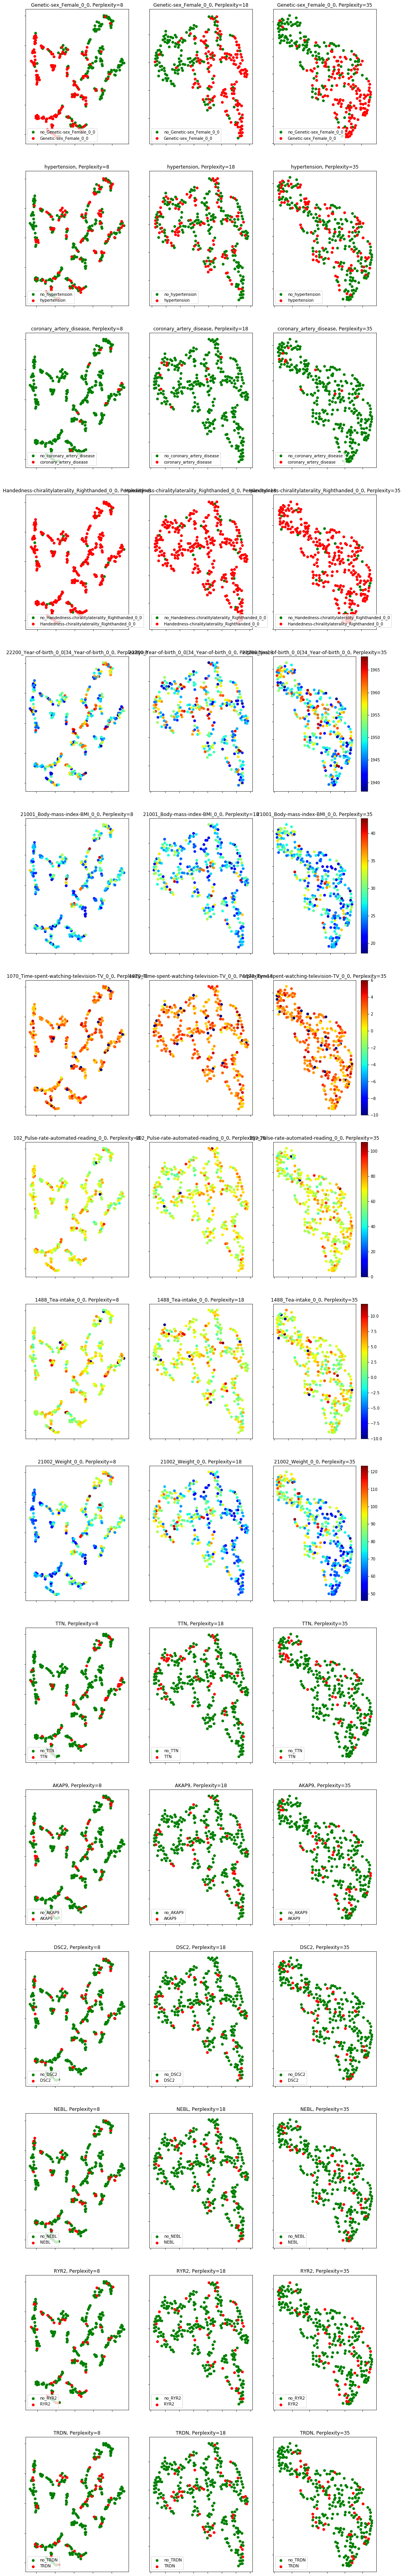

In [10]:
n_components = 2
max_rows = 30
(fig, subplots) = plt.subplots(min(max_rows, len(label_dict)), 3, figsize=(16, max_rows*4))
perplexities = [8, 18, 35]

p2y = {}
for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
    p2y[perplexity] = tsne.fit_transform(x_embed)

j = -1
for k in label_dict:
    j += 1
    if j == max_rows:
        break
    if k in categorical_labels+gene_labels:
        red = label_dict[k] == 1.0
        green = label_dict[k] != 1.0
    elif k in continuous_labels:
        colors = label_dict[k]      
        
    print('process key:', k)
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        ax.set_title(k+", Perplexity=%d" % perplexity)
        if k in categorical_labels+gene_labels:
            ax.scatter(p2y[perplexity][green, 0], p2y[perplexity][green, 1], c="g")
            ax.scatter(p2y[perplexity][red, 0], p2y[perplexity][red, 1], c="r")
            ax.legend(['no_'+k, k], loc='lower left')
        elif k in continuous_labels:
            points = ax.scatter(p2y[perplexity][:, 0], p2y[perplexity][:, 1], c=colors, cmap='jet') 
            if i == len(perplexities)-1:
                fig.colorbar(points, ax=ax)
                
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
plt.show()
